In [66]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

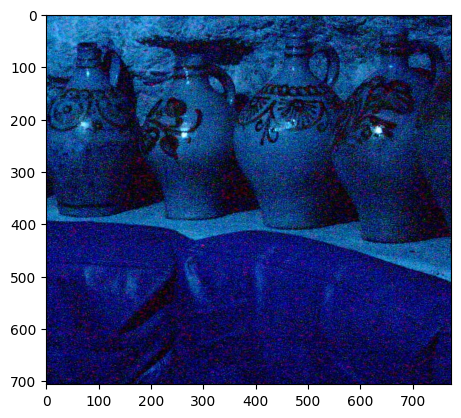

In [67]:
amb_image = cv.imread("ultimate_test/2_a.jpg")
flash_image = cv.imread("ultimate_test/2_b.jpg")
# output_image = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)
plt.imshow(amb_image)

In [68]:
def crossBilateral_filter(image, flash_image, d, sigmaColor, sigmaSpace):
    rows, cols, channels = image.shape
    result = np.zeros_like(image, dtype=np.float32)

    for i in range(rows):
        for j in range(cols):
            pixel = flash_image[i, j].astype(np.float32)

            # Define the pixel neighborhood
            i_min, i_max = max(0, i - d), min(rows, i + d + 1)
            j_min, j_max = max(0, j - d), min(cols, j + d + 1)

            # Extract the neighborhood
            neighborhood_flash = flash_image[i_min:i_max,
                                       j_min:j_max].astype(np.float32)
            neighborhood = image[i_min:i_max,
                                       j_min:j_max].astype(np.float32)

            # Compute Gaussian spatial weights
            i_values = i - np.arange(i_min, i_max)[:, np.newaxis]
            j_values = j - np.arange(j_min, j_max)[np.newaxis, :]

            spatial_weights = np.exp(-((i_values) ** 2 +
                                       (j_values) ** 2) / (2 * sigmaSpace ** 2))

            # Clip the input values before applying the exp function
            intensity_diff = np.clip(neighborhood_flash - pixel, -255, 255)

            # Compute Gaussian intensity weights
            intensity_weights = np.exp(
                -np.sum(intensity_diff ** 2, axis=2) / (2 * sigmaColor ** 2))

            # Combine spatial and intensity weights
            weights = spatial_weights * intensity_weights

            # Normalize the weights
            weights /= np.sum(weights)

            # Update the pixel value in the result image for each channel
            for c in range(channels):
                result[i, j, c] = np.sum(weights * neighborhood[:, :, c])

    return result.astype(np.uint8)


In [69]:
def fShadowFinder(amb_image, flash_image):
    interImage = np.zeros_like(amb_image)
    interImage = amb_image - flash_image
    interImage = cv.cvtColor(interImage, cv.COLOR_BGR2GRAY)
    ret,output = cv.threshold(interImage,50,255,cv.THRESH_BINARY)
    ret,output = cv.threshold(interImage,50,255,cv.THRESH_BINARY)

    specImage = cv.cvtColor(flash_image, cv.COLOR_BGR2HSV)
    (H_channel, S_channel, V_channel) = cv.split(specImage)
    ret,output1 = cv.threshold(V_channel,230,255,cv.THRESH_BINARY_INV)
    output = np.minimum(output1,output)
    return output

def noiseReductionFilter(image, flash_image, d, sigmaColor, sigmaSpace):
    flashMask = fShadowFinder(image, flash_image)
    interImage = crossBilateral_filter(image, image, d, sigmaColor, sigmaColor)
    output = crossBilateral_filter(image, flash_image, d, sigmaColor, sigmaSpace)
    
    for i in range(len(image)):
        for j in range(len(image[0])):
            if flashMask[i,j] == 0:
                output[i,j] = interImage[i,j]
                
    return output

def detMker(image, eps):
    width = len(amb_image[0])
    length = len(amb_image)
    outputImg = amb_image
    blur = cv.bilateralFilter(flash_image,10,100,100)
    outputImg = np.divide(flash_image + eps, blur + eps)
    
    return outputImg

def addDetails(image, amb_image, flash_image, eps):
    outPut = np.zeros_like(image)
    detMask = detMker(flash_image, eps)
    shadowMask = fShadowFinder(amb_image,flash_image)
    for i in range(len(image)):
        for j in range(len(image[0])):
            if shadowMask[i,j] != 0:
                outPut[i,j] = detMask[i,j]*image[i,j]
            else:
                outPut[i,j] = image[i,j]
    
    return outPut

True

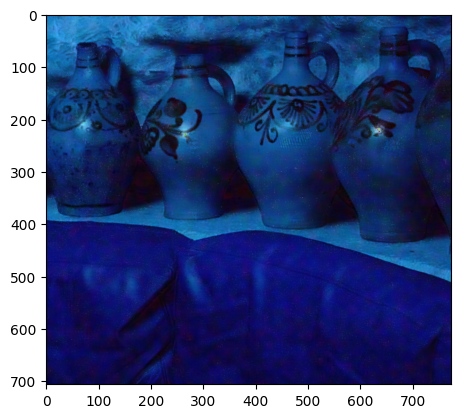

In [70]:
optImage = noiseReductionFilter(amb_image,flash_image,7,30,30)
opt2Image = addDetails(optImage, amb_image, flash_image, 0.02)
plt.imshow(opt2Image)
cv.imwrite("Answer_Q2_1.jpg", optImage)
cv.imwrite("Answer_Q2_2.jpg", opt2Image)